# Простой автоэнкодер

### Подготовка

In [1]:
from keras.datasets import mnist
from keras.layers import Flatten, Dense, Reshape
from keras import Input
from keras.models import Sequential

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

Создадим удобную для нас функцию визуализуации изображений цифр:

In [3]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    _n = min([x.shape[0] for x in args])

    plt.figure(figsize=(2 * _n, 2 * len(args)))
    for j in range(_n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), _n, i * _n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

### Однослойный автоэнкодер

Создадим фабрику простых автоэнкодеров. Для того чтобы подробнее рассмотреть их принцип работы, будем возвращать сами энкодер, декодер и их связку – автоэнкодер:

In [4]:
def create_dense_ae(encoding_dim=(7, 7)):
    _encoding_dim_flatten = encoding_dim[0] * encoding_dim[1]

    encoder_functional = [
        Input(shape=(28, 28)),
        Flatten(),
        Dense(_encoding_dim_flatten, activation='relu'),
        Reshape(encoding_dim)
    ]
    decoder_functional = [
        Flatten(),
        Input(shape=(_encoding_dim_flatten,)),
        Dense(28 * 28, activation='sigmoid'),
        Reshape((28, 28))
    ]

    return Sequential(encoder_functional), Sequential(decoder_functional), Sequential(
        encoder_functional + decoder_functional)

In [5]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

2022-07-22 16:18:45.590361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-22 16:18:45.590539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 49)                38465     
                                                                 
 reshape (Reshape)           (None, 7, 7)              0         
                                                                 
 flatten_1 (Flatten)         (None, 49)                0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 784)               39200     
                                                                 
 reshape_1 (Reshape)

In [6]:
autoencoder.fit(x_train, x_train, epochs=20,
                batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20


2022-07-22 16:18:48.909731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-22 16:18:49.106545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 7ms/step - loss: 0.2558 - val_loss: 0.1725
Epoch 2/20
  1/235 [..............................] - ETA: 1s - loss: 0.1750

2022-07-22 16:18:52.477869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 6ms/step - loss: 0.1543 - val_loss: 0.1373
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1281 - val_loss: 0.1177
Epoch 4/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1125 - val_loss: 0.1055
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1025 - val_loss: 0.0975
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0956 - val_loss: 0.0917
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0905 - val_loss: 0.0875
Epoch 8/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0868 - val_loss: 0.0844
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0843 - val_loss: 0.0824
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0827 - val_loss: 0.0812
Epoch 11/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0817 - val_loss: 0.0804
Epoch 12/

Давайте сравним исходное изображение, результат энкодера и результат последовательного применения энкодера + декодера и просто результат автоэнкодера:

1/1 [==============================] - 0s 7ms/step


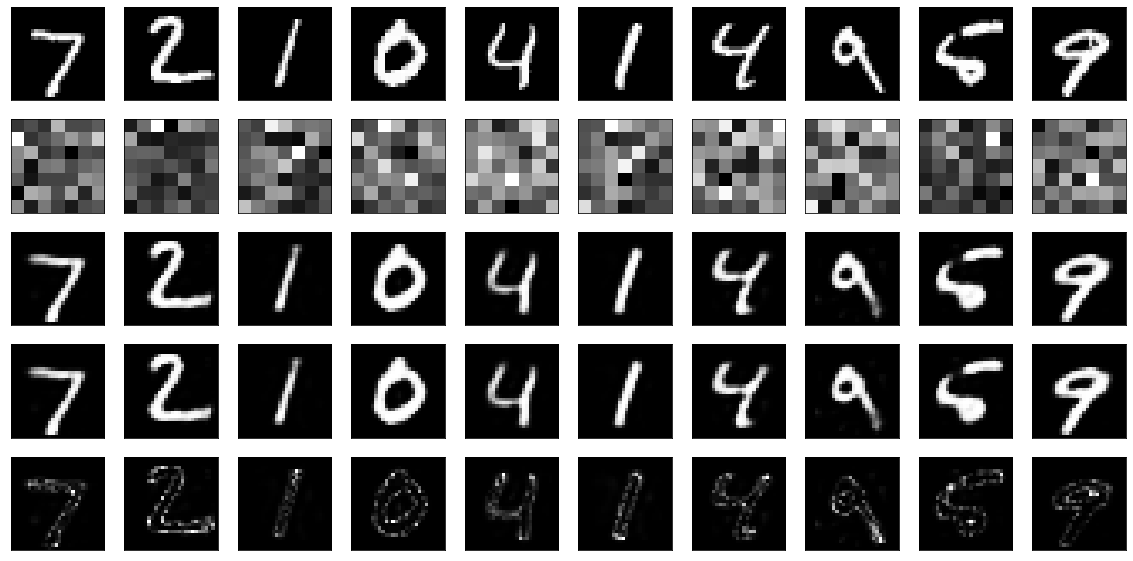

In [10]:
n = 10
imgs = x_test[:n]
encoded = encoder.predict(imgs, batch_size=n)
plot_digits(imgs,
            encoded,
            decoder.predict(encoded, batch_size=n),
            autoencoder.predict(imgs, batch_size=n),
            abs(imgs - autoencoder.predict(imgs, batch_size=n)))

Как мы можем убедиться, последовательное применение энкодера и декодера тождественно применению автоэнкодера (третья и четвертая строки цифр одинаковые), а итог применения энкодера (вторая строка) легко интерпретировать не получится — эта информация имеет смысл лишь для самого декодера.

Можете сравнить первую и третью (или четвертую) строку изображений – входные данные и результат обработки автоэнкодера. Здесь есть небольшие различия: где-то изображение где-то стало быть замыленным (например, низ первой 9-ки), но в целом потеря информации, как может показаться, незначительна. Детально это различие показано в последней строке с изображениями.

### Глубокий автоэнкодер

Может возникнуть вопрос: а можно ли как-то уменьшить количество потери информации, не увеличивая размерность кодируемого изображения?

Да, теоретически можно! Мы можем сделать сеть более глубокой в надежде, что сама сеть будет видеть более сложные признаки и их взаимосвязь. Давайте попробуем:

In [11]:
def create_deep_dense_ae(encoding_dim=(7, 7)):
    _encoding_dim_flatten = encoding_dim[0] * encoding_dim[1]

    encoder_functional = [
        Input(shape=(28, 28)),
        Flatten(),
        Dense(_encoding_dim_flatten * 3, activation='relu'),
        Dense(_encoding_dim_flatten * 2, activation='relu'),
        Dense(_encoding_dim_flatten, activation='linear'),
        Reshape(encoding_dim)
    ]
    decoder_functional = [
        Flatten(),
        Input(shape=(_encoding_dim_flatten,)),
        Dense(_encoding_dim_flatten * 2, activation='relu'),
        Dense(_encoding_dim_flatten * 3, activation='relu'),
        Dense(28 * 28, activation='sigmoid'),
        Reshape((28, 28))
    ]

    return Sequential(encoder_functional), Sequential(decoder_functional), Sequential(
        encoder_functional + decoder_functional)

In [12]:
deep_encoder, deep_decoder, deep_autoencoder = create_deep_dense_ae()
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
deep_autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 147)               115395    
                                                                 
 dense_3 (Dense)             (None, 98)                14504     
                                                                 
 dense_4 (Dense)             (None, 49)                4851      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7)              0         
                                                                 
 flatten_3 (Flatten)         (None, 49)                0         
                                                                 
 input_4 (InputLayer)        multiple                 

In [13]:
deep_autoencoder.fit(x_train, x_train, epochs=20,
                     batch_size=256, shuffle=True,
                     validation_data=(x_test, x_test))

Epoch 1/20


2022-07-22 16:25:11.430869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 9ms/step - loss: 0.2230 - val_loss: 0.1486
Epoch 2/20
  1/235 [..............................] - ETA: 1s - loss: 0.1501

2022-07-22 16:25:13.703685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 2s 8ms/step - loss: 0.1332 - val_loss: 0.1201
Epoch 3/20
235/235 [==============================] - 2s 8ms/step - loss: 0.1158 - val_loss: 0.1095
Epoch 4/20
235/235 [==============================] - 2s 8ms/step - loss: 0.1076 - val_loss: 0.1033
Epoch 5/20
235/235 [==============================] - 2s 7ms/step - loss: 0.1028 - val_loss: 0.1000
Epoch 6/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0993 - val_loss: 0.0965
Epoch 7/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0963 - val_loss: 0.0941
Epoch 8/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0938 - val_loss: 0.0916
Epoch 9/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0918 - val_loss: 0.0900
Epoch 10/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0903 - val_loss: 0.0886
Epoch 11/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0888 - val_loss: 0.0873
Epoch 12/

Можем сами сравнить исходные изображения, результаты работы автоэнкодера и результаты работы глубокого автоэнкодера:

1/1 [==============================] - 0s 8ms/step


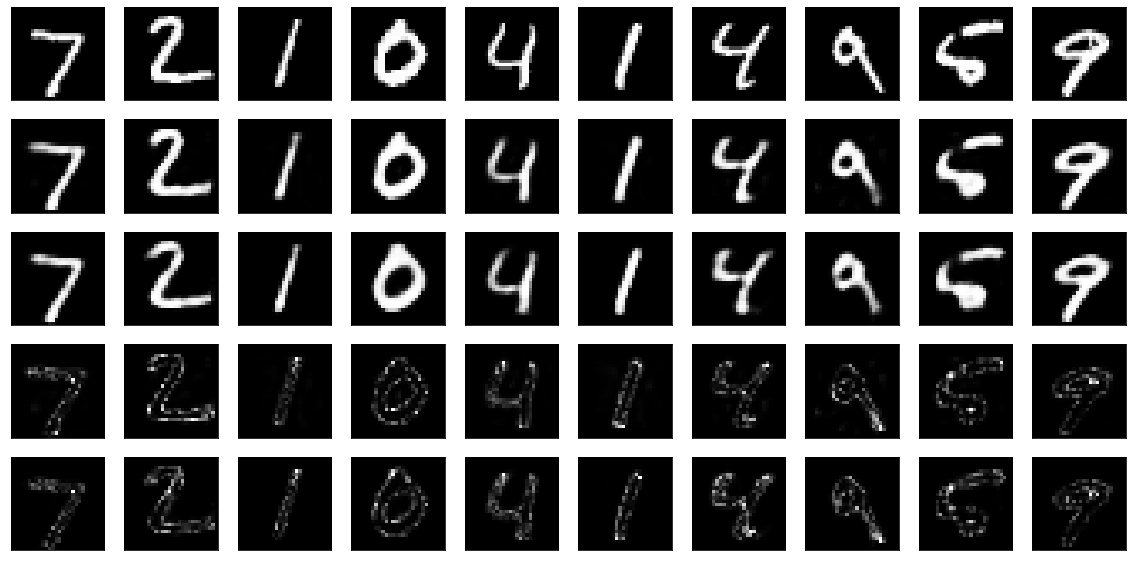

In [15]:
n = 10
imgs = x_test[:n]
plot_digits(imgs,
            autoencoder.predict(imgs, batch_size=n), deep_autoencoder.predict(imgs, batch_size=n),
            abs(imgs - autoencoder.predict(imgs, batch_size=n)),
            abs(imgs - deep_autoencoder.predict(imgs, batch_size=n)))

Практически ничего не поменялось: 9ка стала четче внизу, 7ка немного расплывчата и т.д.. Давайте посмотрим на разность последних двух сетов изображений:

1/1 [==============================] - 0s 9ms/step


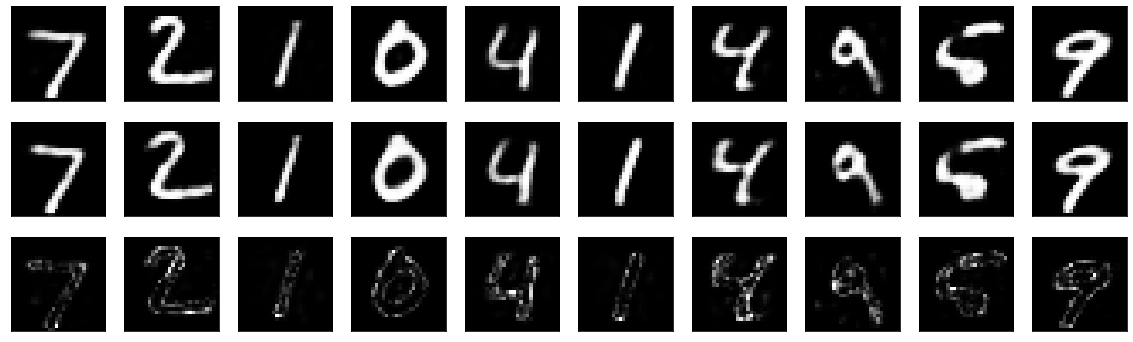

In [16]:
n = 10
imgs = x_test[:n]
plot_digits(autoencoder.predict(imgs, batch_size=n), deep_autoencoder.predict(imgs, batch_size=n),
            abs(autoencoder.predict(imgs, batch_size=n) - deep_autoencoder.predict(imgs, batch_size=n)))

Действительно, ничего сильно не изменилось с углублением сети.

Итак, мы познакомились с автоэнкодерами поближе и поняли их принцип работы.
